In [1]:
# import newly developed scripts
import sys
sys.path.append('/Users/nweir/Dropbox/code/csth-imaging')
from csth_analysis.analysis_scripts import czi_io, find_cells
import numpy as np
import os
from skimage import io, measure
from scipy.ndimage import filters
import matplotlib.pyplot as plt
from scipy import stats

/usr/local/lib/python3.6/site-packages/tifffile.py:313: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "
/usr/local/lib/python3.6/site-packages/czifile.py:130: UserWarning: failed to import the optional _czifile C extension module.
Decoding of JXR and JPEG encoded images will not be available.
Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _czifile C extension module.\n"


This seems to import the image fine. I need to get a sample background image too, then I'll try to find cells using this.

In [2]:
os.chdir('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/')
test_finder = find_cells.MultiFinder('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/LC3-p62_HEK_WT_Torin_ClumpsandSingles_Airyscan Processing.czi',
                                    bg_filename = '/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/LC3-p62_HEK_dVPS37A_No Torin_EMPTY_AiryscanProcessing.czi')

In [3]:
output = test_finder.find_cells(488)

log-transforming arrays...
applying gaussian filter...
computing p-value transformation...
converting to binary...

generating cell masks...

generating mask #1
labeling contiguous objects...
eliminating objects w/volume < 100,000 px...
pruning labels...
appending outputs...
mask #1 complete.

generating mask #2
labeling contiguous objects...
eliminating objects w/volume < 100,000 px...
pruning labels...
appending outputs...
mask #2 complete.

generating mask #3
labeling contiguous objects...
eliminating objects w/volume < 100,000 px...
pruning labels...
appending outputs...
mask #3 complete.

generating mask #4
labeling contiguous objects...
eliminating objects w/volume < 100,000 px...
pruning labels...
appending outputs...
mask #4 complete.

generating mask #5
labeling contiguous objects...
eliminating objects w/volume < 100,000 px...
pruning labels...
appending outputs...
mask #5 complete.



In [4]:
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/output_test.tiff', output[0].astype('uint16'))

/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/output_test.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, 

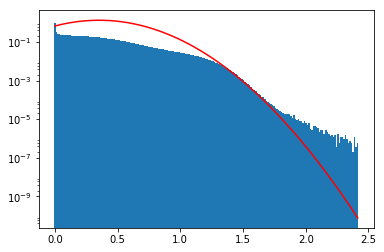

In [21]:
im_arrs = test_finder.get_channel_arrays(488)
log_f_im = np.log10(im_arrs[0]+1)
log_bg_im = np.log10(im_arrs[1]+1)
log_gaussian_f = filters.gaussian_filter(log_f_im, sigma=[0,0,3,3])
log_gaussian_bg = filters.gaussian_filter(log_bg_im, sigma=[0,0,3,3])
log_bg_mean = np.mean(log_gaussian_bg)
log_bg_sd = np.std(log_gaussian_bg)
n, bins= np.histogram(log_gaussian_bg, 200)
n = n/np.amax(n)
plt.bar(bins[:-1],n,width = bins[1]-bins[0])
norm_pdf = stats.norm.pdf(bins[:-1], log_bg_mean, log_bg_sd)
plt.plot(bins[:-1], norm_pdf, color = 'red')
plt.yscale('log', nonposy='clip')

plt.show()

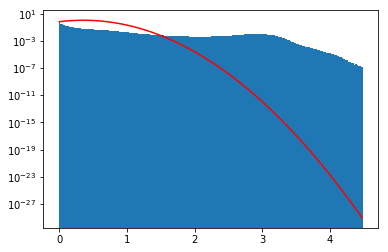

In [16]:
n, bins= np.histogram(log_gaussian_f, 200)
n = n/np.amax(n)
plt.bar(bins[:-1],n,width = bins[1]-bins[0])
norm_pdf = stats.norm.pdf(bins[:-1], log_bg_mean, log_bg_sd)
plt.plot(bins[:-1], norm_pdf, color = 'red')
plt.yscale('log', nonposy='clip')


plt.show()

This is clearly a terrible fit but it _looks_ like it should work for my purposes (all of the dim stuff that likely corresponds to background matches in the two images, whereas there's more bright stuff in the + cells image.

In [22]:
f_pvals = 1-stats.norm.cdf(log_gaussian_f, log_bg_mean, log_bg_sd)
f_pvals = f_pvals*65535 
f_pvals = f_pvals.astype('uint16')

In [23]:
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/pvals_test.tif', f_pvals)

In [58]:
f_pvals_binary = np.copy(f_pvals)
f_pvals_binary[f_pvals > 0] = 0
f_pvals_binary[f_pvals == 0] = 1

In [59]:
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/binary_pvals_test.tif', f_pvals_binary)

/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/binary_pvals_test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [74]:
curr_im = f_pvals_binary[0, :, :, :]
r_labs = measure.label(curr_im, connectivity=2, background=0)
objs_w_cts = np.unique(r_labs[r_labs != 0], return_counts=True)
cell_mask = np.reshape(np.in1d(
    r_labs, objs_w_cts[0][objs_w_cts[1] > 100000]),
                       r_labs.shape)
trim_labs = np.copy(r_labs)
trim_labs[np.invert(cell_mask)] = 0


In [76]:
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/curr_im_test.tif', curr_im.astype('uint16'))
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/raw_labs_test.tif', r_labs.astype('uint16'))
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/trimmed_labs_test.tif', trim_labs.astype('uint16'))
io.imsave('/Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/cell_mask_test.tif', cell_mask.astype('uint16'))

/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/curr_im_test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/raw_labs_test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/trimmed_labs_test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/nweir/Dropbox/chris_imaging/imaging_test/th_sample_czi/cell_mask_test.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [70]:
curr_im.shape

(51, 1112, 1112)

In [75]:
objs_w_cts

(array([   1,    2,    3, ..., 1189, 1190, 1191]),
 array([       9, 13584160,        2, ...,        3,        3,       17]))

In [72]:
print(objs_w_cts)

(array([   0,    1,    2, ..., 1189, 1190, 1191]), array([49442110,        9, 13584160, ...,        3,        3,       17]))


In [73]:
objs_w_cts[0][objs_w_cts[1] > 100000]

array([0, 2])